This is going to be an out of the box version of alt_means that can be easily edited, changed parameters and played with easily when using for other things in other places.
pip install ipynb and use the code: from ipynb.fs.full.alt_means_ootb import alt_means_ootb to get a function that returns labels, and element centric sim with ground truth



In [1]:
# let's get the machinery going

import numpy as np
from scipy import sparse
import pandas as pd
from copy import deepcopy

from sklearn.cluster import KMeans 
from sklearn.cluster import OPTICS, DBSCAN
from sklearn.linear_model import LogisticRegression 
import faiss
import fast_hdbscan
import embcom

import lfr
import embcom
import csv
import sys
sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")

from scripts.nets_and_embeddings import create_and_save_network_and_embedding
from scripts.clustering_methods import clustering_method_values

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans, splitting_type
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES
import numpy as np
import belief_propagation
import infomap

from graph_tool.all import Graph,minimize_blockmodel_dl

import graph_tool.all as gt
import numpy as np
import pandas as pd
from scipy import sparse, stats
from scipy.sparse.csgraph import connected_components

ImportError: cannot import name 'clustering_method_values' from 'scripts.clustering_methods' (/nobackup/gogandhi/alt_means_sans_k/scripts/clustering_methods.py)

In [24]:
# Define a function that calculates element-centric similarity:
def calc_esim(y, ypred):

    ylab, y = np.unique(y, return_inverse=True)
    ypredlab, ypred = np.unique(ypred, return_inverse=True)
    
    Ka, Kb = len(ylab), len(ypredlab)
    K = np.maximum(Ka, Kb)
    N = len(y)
    
    UA = sparse.csr_matrix((np.ones_like(y), (np.arange(y.size), y)), shape=(N,K))
    UB = sparse.csr_matrix((np.ones_like(ypred), (np.arange(ypred.size), ypred)), shape=(N, K))    
    
    nA = np.array(UA.sum(axis=0)).reshape(-1)
    nB = np.array(UB.sum(axis=0)).reshape(-1)

# nAB[i][j] is read as the number of elements that belong to ith ground truth label and jth predicrted label.
# nAB[1][0] = 1 For ground truth label with index 1 and predicted label 0 we have 1 element. i.e. 0000|1| vs 1110|0|

    nAB = (UA.T @ UB).toarray()
    nAB_rand = np.outer(nA, nB) / N
    
# assuming that each element has an equal probability of being assigned to any label,
# and the expected counts are calculated based on label frequencies.


    # Calc element-centric similarity
    Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    Q = 1 / np.maximum(Q, 1)
    S = np.sum(np.multiply(Q, (nAB**2))) / N
    
    # Calc the expected element-centric similarity for random partitions
    #Q = np.maximum(nA[:, None] @ np.ones((1, K)), np.ones((K, 1)) @ nB[None, :]) 
    #Q = 1 / np.maximum(Q, 1)
    Srand = np.sum(np.multiply(Q, (nAB_rand**2))) / N
    Scorrected = (S - Srand) / (1 - Srand)
    return Scorrected

In [2]:
def find_knn_edges(emb, num_neighbors, 
                   target=None, metric="dotsim",
                   device=None):
    
    k = int(np.minimum(num_neighbors + 1, emb.shape[0]).astype(int))
    indices, distances = find_knn(emb if target is None else target, emb,
                                  num_neighbors=k,
                                  metric=metric,
                                  device=device)
    r = np.outer(np.arange(indices.shape[0]), np.ones((1, indices.shape[1]))).astype(int)
    r, c, distances = (r.reshape(-1),indices.astype(int).reshape(-1),distances.reshape(-1))
    if len(r) == 0:
        return r, c, distances 
    
    return r, c, distances

# Only place where GPU is used, need to handle its closing. 
def find_knn(target, emb, num_neighbors, metric="dotsim", device=None): 
    if metric == "dotsim":
        index = faiss.IndexFlatIP(emb.shape[1]) 
    elif metric == "euclidean":
        index = faiss.IndexFlatL2(emb.shape[1])
    elif metric == "manhattan":
        index = faiss.IndexFlatL1(emb.shape[1])
    elif metric == "cosine":
        index = faiss.IndexFlatIP(emb.shape[1])
        emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    elif metric=="mahalanobis":
        # THis mathematical trick works, but it needs some reworking in target.astype to
        # give right results.
        # map the vectors back to a space where they follow a unit Gaussian
        xc = emb - emb.mean(0)
        cov = np.dot(xc.T, xc) / xc.shape[0]
        L = np.linalg.cholesky(cov)
        mahalanobis_transform = np.linalg.inv(L)
        emb = np.dot(emb, mahalanobis_transform.T)
        index = faiss.IndexFlatL2(emb.shape[1])
    else:
        raise ValueError("Invalid metric specified.")
    
    if device is None:
        index.add(emb.astype(np.float32))
        distances, indices = index.search(target.astype(np.float32), k=num_neighbors)
        # This line takes too long to load.
    else: 
        try:
            gpu_id = int(device[-1])
            res = faiss.StandardGpuResources()
            index = faiss.index_cpu_to_gpu(res, gpu_id, index)
            index.add(emb.astype(np.float32))
            distances, indices = index.search(
                target.astype(np.float32), k=num_neighbors
            )
        except RuntimeError:
            if metric == "dotsim":
                index = faiss.IndexFlatIP(emb.shape[1]) 
            elif metric == "euclidean":
                index = faiss.IndexFlatL2(emb.shape[1])
            elif metric == "manhattan":
                index = faiss.IndexFlatL1(emb.shape[1])
            elif metric == "cosine":
                index = faiss.IndexFlatIP(emb.shape[1])
                emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
            else:
                raise ValueError("Invalid metric specified.")
            
            index.add(emb.astype(np.float32))
            distances, indices = index.search(target.astype(np.float32),
                                              k=num_neighbors)
        
    index.reset()
    return indices, distances

In [3]:
import numba

def louvain(Z, w1, b0, num_neighbors=10, iteration = 50, device = "cuda:0", return_member_matrix=False):
    """"Louvain algorithm for vecto data
    :param Z: embedding
    :type Z: numpy.ndarray
    :param w1: regression coefficient
    :type w1: float
    :param b0: intercept
    :type b0: float
    :param num_neighbors: Number of neighbors, defaults to 100
    :type num_neighbors: int, optional
    :param iteration: The maximum number of iterations, defaults to 50
    :type iteration: int, optional
    :param device: _description_, defaults to "cuda:0"
    :type device: str, optional
    :param return_member_matrix: _description_, defaults to False
    :type return_member_matrix: bool, optional
    :return: _description_
    :rtype: _type_
    """
    # Initialize the intermediate variables
    num_nodes = Z.shape[0]
    node_size = np.ones(num_nodes)
    U = sparse.identity(num_nodes, format="csr")
    Vt = Z.copy()
    
    # The main loop for the Louvain algorithm
    while True:
        # Find the community assignment for the given graph # using a label switching algorithm
        cids_t = label_switching(
               Z=Vt,
               num_neighbors=num_neighbors,
               rho=b0/w1,
               node_size=node_size,
               epochs=iteration,
               device=device,
                )
        
        # This is to make the community labels continuous integer variables
        _, cids_t = np.unique(cids_t, return_inverse=True)
        
        # If no merging, we are good to go out from the loop
        if int(max(cids_t) + 1) == Vt.shape[0]: 
            break
            
        # If two nodes are merged, we created an aggregated network, 
        #where a node represents a community.
        
        num_nodes_t = len(cids_t)
        k = int(np.max(cids_t) + 1)
        Ut = sparse.csr_matrix((np.ones(num_nodes_t), (np.arange(num_nodes_t), cids_t)), shape=(num_nodes_t, k))
        U = U @ Ut
        Vt = Ut.T @ Vt
        
        node_size = np.array(Ut.T @ node_size).reshape(-1)
    if return_member_matrix: 
        return U
    cids = np.array((U @ sparse.diags(np.arange(U.shape[1]))).sum(axis=1)).reshape(-1)

    return cids

#
# Clustering based on a label switching algorithm
#
def label_switching(Z, rho, num_neighbors=50, node_size=None, device=None,epochs=50): # This involves distance metrics (cosine similarity, atm)
    num_nodes, dim = Z.shape
    if node_size is None:
        node_size = np.ones(num_nodes)
    Z = Z.copy(order="C").astype(np.float32)
    # Construct the candidate graph
    Z1 = np.hstack([Z, np.ones((num_nodes, 1))])
    Zrho = np.hstack([Z, -rho * node_size.reshape((-1, 1))])

    r, c, v = find_knn_edges(
        Zrho,
        target=Z1,
        num_neighbors=num_neighbors,
        metric="cosine",
        device=device)
    A = sparse.csr_matrix((v, (r, c)), shape=(num_nodes, num_nodes))
    
    return _label_switching_(
        A_indptr=A.indptr,
        A_indices=A.indices,
        Z=Z,
        num_nodes=num_nodes,
        rho=rho,
        node_size=node_size,
        epochs=epochs)

#@numba.jit(nopython=True, cache=True)
def _label_switching_(A_indptr, A_indices, Z, num_nodes, rho, node_size,epochs=100):
    Nc = np.zeros(num_nodes)
    cids = np.arange(num_nodes)
    Vc = Z.copy()
    Vnorm = np.sum(np.multiply(Z, Z), axis=1).reshape(-1) 
    for nid in range(num_nodes):
            Nc[nid] += node_size[nid]
    for _it in range(epochs):
        order = np.random.choice(num_nodes, size=num_nodes, replace=False) 
        updated_node_num = 0
        
        for _k, node_id in enumerate(order):
            # Get the weight and normalized weight
            neighbors = A_indices[A_indptr[node_id] : A_indptr[node_id + 1]]

            # Calculate the grain
            c = cids[node_id]
            clist = np.unique(cids[neighbors])
            next_cid = -1
            dqmax = 0
            qself = (
                np.sum(Z[node_id, :] * Vc[c, :])
                - Vnorm[node_id]
                - rho * node_size[node_id] * (Nc[c] - node_size[node_id]))

            for cprime in clist:
                if c == cprime: 
                    continue
                dq = (np.sum(Z[node_id, :] * Vc[cprime, :])
                        - rho * node_size[node_id] * Nc[cprime]) - qself
                if dqmax < dq:
                    next_cid = cprime
                    dqmax = dq
            if dqmax <= 1e-16: 
                continue

            Nc[c] -= node_size[node_id]
            Nc[next_cid] += node_size[node_id]

            Vc[c, :] -= Z[node_id, :]
            Vc[next_cid, :] += Z[node_id, :]

            cids[node_id] = next_cid
            updated_node_num += 1

        if (updated_node_num / np.maximum(1, num_nodes)) < 1e-3: 
            break
    return cids
 

In [ ]:
def clustering_method_values(net, community_table, emb, score_keys, device_name):



    # Normalize the vector of each node to have unit length. This normalization improves clustering.
    X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
    X = emb.copy()
    # Clustering

    def proposed_method_labels(emb,device_name):
        rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=500, device = device_name)
        cneg = np.random.choice(emb.shape[0], len(cpos))
        vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

        model = LogisticRegression()
        model.fit(
            np.concatenate([vpos, vneg]).reshape((-1, 1)),
            np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
                )
        w1, b0 = model.coef_[0, 0], -model.intercept_[0] 
        return louvain(emb, w1, b0, device = device_name)

    # Evaluate the clustering
    def method_score(key):
        if key == "kmeans": # Does use k
            kmeans = KMeans(n_clusters= len(set(community_table["community_id"])), random_state=0).fit(X)
            return calc_esim(community_table["community_id"], kmeans.labels_)
        
        if key == "dbscan": # Does kinda use k (kinda we give k as minimum cluster size to avoid errors)
            
            clusterer = fast_hdbscan.HDBSCAN(min_cluster_size=len(set(community_table["community_id"])))
            dbscan_labels = clusterer.fit_predict(X)
            return calc_esim(community_table["community_id"], dbscan_labels)
        
        if key == "optics": # Does not use k
            optics = OPTICS().fit(X)
            return calc_esim(community_table["community_id"], optics.labels_)
        
        if key == "proposed": # Does not use k
            return calc_esim(community_table["community_id"], proposed_method_labels(emb,device_name)) 
        
        if key == "xmeans": # Does use k
            # Create instance of X-Means algorithm with MNDL splitting criterion.
            initial_centers = kmeans_plusplus_initializer(X, amount_centers=len(set(community_table['community_id']))).initialize()
            xmeans_mndl = xmeans(X, initial_centers, 20, splitting_type=splitting_type.MINIMUM_NOISELESS_DESCRIPTION_LENGTH)
            xmeans_mndl.process()
            mndl_clusters = xmeans_mndl.get_clusters()
            xmeans_labels = [i[1] for i in sorted([(j,i) for i in range(len(mndl_clusters)) for j in mndl_clusters[i]])]

            return calc_esim(community_table["community_id"], xmeans_labels)
        
        if key == "belief_prop": # Does use k
            belief_prop_labels = belief_propagation.detect(net, q=len(set(community_table['community_id'])), init_memberships=community_table["community_id"]) 
            return calc_esim(community_table["community_id"], belief_prop_labels)
        
        if key == "infomap": # Does not use k
            r, c, v = sparse.find(net + net.T)
            im = infomap.Infomap(silent=True)
            for i in range(len(r)):
                im.add_link(r[i], c[i], 1)
            im.run()
            
            cids = np.zeros(net.shape[0])
            for node in im.tree:
                if node.is_leaf:
                    cids[node.node_id] = node.module_id
                    
            infomap_labels = np.unique(cids, return_inverse=True)[1]

            return calc_esim(community_table["community_id"], infomap_labels)
            
        if key == "flatsbm": # Does use k
            r, c, v = sparse.find(net)
            g = Graph(directed=False)
            g.add_edge_list(np.vstack([r, c]).T)
            K = len(set(community_table['community_id']))
            state = minimize_blockmodel_dl(
                g,
                state_args={"B_min": K, "B_max": K},
                multilevel_mcmc_args={"B_max": K, "B_min": K},
            )
            b = state.get_blocks()
            flatsbm_labels = np.unique(np.array(b.a), return_inverse=True)[1]
            return calc_esim(community_table["community_id"], flatsbm_labels)
            
    score_dictionary={}
    for key in score_keys:
        score_dictionary[key] = method_score(key)
    
    return score_dictionary

def get_scores(params= None, emb_params = None, score_keys = None, path_name = None, device_name = "cuda:0"):
    
    
    # Defaults
    if params is None:
        params = {
            "N": 100000,     # number of nodes
            "k": 50,       # average degree
            "maxk": 1000,   # maximum degree sqrt(10*N)
            "minc": 50,    # minimum community size
            "maxc": 1000,   # maximum community size sqrt(10*N)
            "tau": 3.0,    # degree exponent
            "tau2": 1.8,   # community size exponent / 1.2 default
            "mu": 0.2,     # mixing rate
        }
    if emb_params is None:
        emb_params = {      "method": "node2vec",
                            "window_length": 10,
                            "walk_length": 80,
                            "num_walks": 10,
                            "dim" : 64,
                            }
    
    if score_keys is None:
        score_keys = ['kmeans', 'dbscan', 'optics', 'proposed','xmeans','belief_prop','infomap','flatsbm']
    
    # Allowing existing files in path to be uses. We might need to generate all nets and embeddings first and then proceed to clustering.
    # Easier for snakemake as well.

    net, community_table, emb = create_and_save_network_and_embedding(params,emb_params, path_name, save_file=True)

    return clustering_method_values(net, community_table, emb, score_keys,device_name), net, community_table, emb

In [5]:
def alt_means_ootb(emb, communities, device_name="cuda:0", num_neighbors=500): 
    # Here emb is just an array of datapoints, where each row corresponds to a d dimensional array corresponding to a point.
    # Community table is an array with community partitions, which will be converted 
    # below into a pandas dataframe, with 'community_id' column containing the array data.

    

    # Normalize the vector of each node to have unit length. This normalization improves clustering.
    X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
    X = emb.copy()
    # Clustering


    rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=num_neighbors, device = device_name)
    cneg = np.random.choice(emb.shape[0], len(cpos))
    vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

    model = LogisticRegression()
    model.fit(
        np.concatenate([vpos, vneg]).reshape((-1, 1)),
        np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
            )
    w1, b0 = model.coef_[0, 0], -model.intercept_[0] 

    kmeans = KMeans(n_clusters= len(set(community_table["community_id"])), random_state=0).fit(X)
    kmeans_esim = calc_esim(communities, kmeans.labels_)
        
    
    proposed_labels = louvain(emb, w1, b0, device = device_name)
    esim = calc_esim(communities, proposed_labels) 
        
    
    return proposed_labels, esim #, kmeans_labels, kmeans_esim 

  

In [ ]:
#### IGNORE EVERYTHING BELOWWW

In [21]:
N=100000
params = {
    "N": N,
    "k": 50,
    "maxk":  int(np.sqrt(10 * N)),
    "minc": 50,
    "maxc": int(np.ceil(np.sqrt(N * 10))),
    "tau": 3.0,
    "tau2": 1.8,
    "mu": 0.2,
    }


emb_params = {      "method": "node2vec",
                            "window_length": 10,
                            "walk_length": 80,
                            "num_walks": 10,
                            "dim" : 64,
                            }
    
path_name="/nobackup/gogandhi/alt_means_sans_k/data/inhomegeneity_tests/"

net, community_table, emb = create_and_save_network_and_embedding(params,emb_params, path_name, save_file=True)

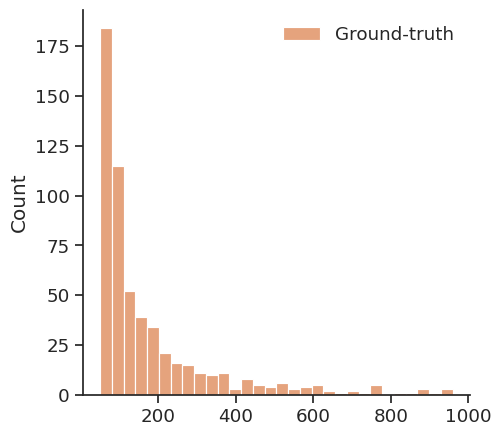

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

clus_sz = np.unique(community_table["community_id"], return_counts=True)[1]
#clus_sz_kmeans = np.unique(kmeans.labels_, return_counts=True)[1]
sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(5,5))
#sns.histplot(clus_sz_kmeans, bins = 30, label = "K-means", ax = ax)
sns.histplot(clus_sz, bins = 30, color = sns.color_palette().as_hex()[1], label= "Ground-truth", ax = ax)
ax.legend(frameon = False)
sns.despine()

In [26]:
# Normalize the vector of each node to have unit length. This normalization improves clustering.
X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
X = emb.copy()

# Clustering

kmeans = KMeans(n_clusters= len(set(community_table["community_id"])), random_state=0).fit(X)
kmeans_esim =  calc_esim(community_table["community_id"], kmeans.labels_)

In [ ]:
def proposed_method_labels(emb,device_name):
    rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=500, device = device_name)
    cneg = np.random.choice(emb.shape[0], len(cpos))
    vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

    model = LogisticRegression()
    model.fit(
        np.concatenate([vpos, vneg]).reshape((-1, 1)),
        np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
            )
    w1, b0 = model.coef_[0, 0], -model.intercept_[0] 
    return louvain(emb, w1, b0, device = device_name)

device_name="cuda:0"
proposed_labels =  proposed_method_labels(emb,device_name)

proposed_esim = calc_esim(community_table["community_id"], proposed_labels) 
# Evaluate the clustering

In [29]:
proposed_esim

0.9131392762096961

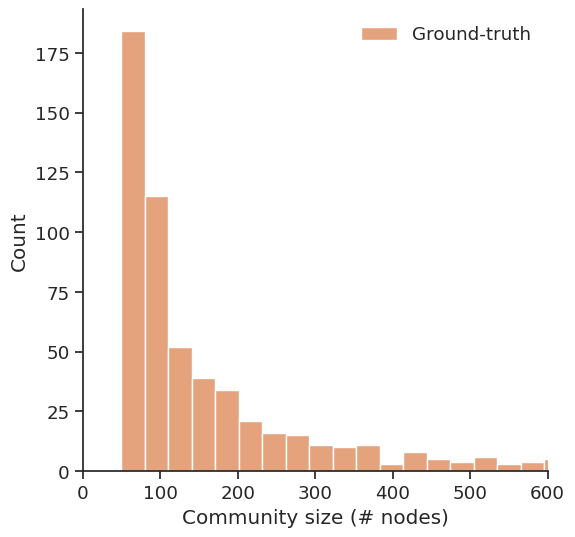

In [49]:
clus_sz = np.unique(community_table["community_id"], return_counts=True)[1]
clus_sz_kmeans = np.unique(kmeans.labels_, return_counts=True)[1]
clus_sz_altmeans = np.unique(proposed_labels, return_counts=True)[1]
sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(6,6))

sns.histplot(clus_sz, bins = 30, color = sns.color_palette().as_hex()[1], label= "Ground-truth", ax = ax)
#sns.histplot(clus_sz_altmeans, bins = 30, label = "K-means",color = sns.color_palette().as_hex()[2], ax = ax)
#sns.histplot(clus_sz_kmeans, bins = 30, label = "Alt-means", ax = ax)
ax.set_xlim([0,600])
ax.legend(frameon = False)
ax.set_xlabel("Community size (# nodes)")  # Add the x-label
sns.despine()